In [1]:
import random
import json
import numpy as np
import pandas as pd

import skimage

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from torchvision.models._utils import IntermediateLayerGetter

from models.modeling.deeplab import *
from dataloader.talk2car import *

import denseCRF
import pydensecrf.densecrf as dcrf

from PIL import Image
from skimage.transform import resize

from losses import Loss
from models.model import JointModel

from utils.im_processing import *
from utils.metrics import *

from summarizer import Summarizer

from collections import Counter

comet_ml is installed but `COMET_API_KEY` is not set.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class Args:
    lr = 3e-4
    batch_size = 64
    num_workers = 4
    image_encoder = "deeplabv3_plus"
    num_layers = 1
    num_encoder_layers = 1
    dropout = 0.25
    skip_conn = False
    model_path = "./saved_model/talk2car/deeplabv3_plus_talk2car_1_bce_0.52071.pth"
    loss = "bce"
    dataroot = "/ssd_scratch/cvit/kanishk/"
    glove_path = "/ssd_scratch/cvit/kanishk/glove/"
    dataset = "talk2car"
    task = "talk2car"
    split = "val"
    seq_len = 25
    image_dim = 448
    mask_dim = 448
    mask_thresh = 0.1
    area_thresh = 0.4
    topk = 10

args = Args()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_gpu = torch.cuda.device_count()
print(f'{device} being used with {n_gpu} GPUs!!')

cuda being used with 2 GPUs!!


In [5]:
print("Initializing dataset")

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()
resize = transforms.Resize((args.image_dim, args.image_dim))

tokenizer = None

if args.dataset == "referit":
    val_dataset = ReferDataset(
        data_root=args.dataroot,
        dataset=args.task,
        transform=transforms.Compose([resize, to_tensor, normalize]),
        annotation_transform=transforms.Compose([ResizeAnnotation(args.mask_dim)]),
        split=args.split,
        max_query_len=args.seq_len,
        glove_path=args.glove_path,
    )
else:
    val_dataset = Talk2Car(
        root=args.dataroot,
        split=args.split,
        transform=transforms.Compose([resize, to_tensor, normalize]),
        mask_transform=transforms.Compose([ResizeAnnotation(args.mask_dim)]),
        glove_path=args.glove_path
    )

val_loader = DataLoader(
    val_dataset, shuffle=True, batch_size=1, num_workers=0, pin_memory=True
)

Initializing dataset


In [6]:
return_layers = {"layer2": "layer2", "layer3": "layer3", "layer4": "layer4"}

model = DeepLab(num_classes=21, backbone="resnet", output_stride=16)
model.load_state_dict(torch.load("./models/deeplab-resnet.pth.tar")["state_dict"])

image_encoder = IntermediateLayerGetter(model.backbone, return_layers)

for param in image_encoder.parameters():
    param.requires_grad_(False)

In [7]:
in_channels = 2048
out_channels = 512
stride = 2

joint_model = JointModel(
    in_channels=in_channels,
    out_channels=out_channels,
    stride=stride,
    num_layers=args.num_layers,
    num_encoder_layers=args.num_encoder_layers,
    dropout=args.dropout,
    skip_conn=args.skip_conn,
    mask_dim=args.mask_dim,
)

state_dict = torch.load(args.model_path)
if "state_dict" in state_dict:
    state_dict = state_dict["state_dict"]
joint_model.load_state_dict(state_dict) 

<All keys matched successfully>

In [8]:
if n_gpu > 1:
    image_encoder = nn.DataParallel(image_encoder)

joint_model.to(device)
image_encoder.to(device)

image_encoder.eval();
joint_model.eval();

In [9]:
summarizer = Summarizer()

In [10]:
loss_func = Loss(args)
val_iter = iter(val_loader)

In [11]:
def compute_mask_IOU(masks, target, thresh=0.3):
    assert(target.shape[-2:] == masks.shape[-2:])
    temp = ((masks>thresh) * target)
    intersection = temp.sum()
    union = (((masks>thresh) + target) - temp).sum()
    return intersection, union

def meanIOU(m, gt, t):
    temp = ((m > t)*gt)
    inter = temp.sum()
    union = ((m > t) + gt - temp).sum()
    return inter/union

### Example Visualization

In [12]:
val_iter = iter(val_loader)

In [24]:
data_len = val_dataset.__len__()
indx = random.choice(range(data_len))
batch = val_dataset.__getitem__(indx)

(448, 448)
park near the left car


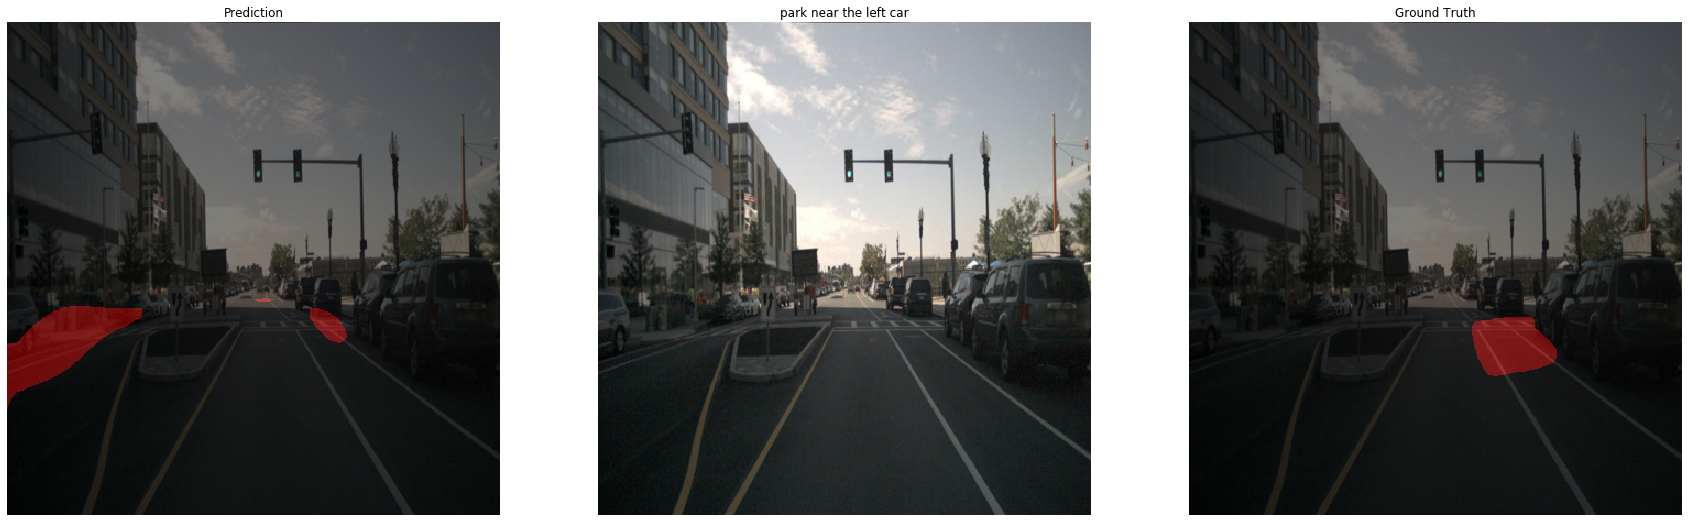

IOU overlab with ground truth: 0.0, bestIOU: 0.015744579955935478, best_t: 0.01


In [26]:
# batch = val_iter.next()

img = batch["image"].cuda(non_blocking=True).unsqueeze(0)

# phrase = batch["phrase"].cuda(non_blocking=True)
# phrase_mask = batch["phrase_mask"].cuda(non_blocking=True)

### Custom Phrase ###
batch["orig_phrase"] = "park near the left car"
# batch["orig_phrase"] = summarizer(batch["orig_phrase"])
phrase, phrase_mask = val_dataset.vocabulary.tokenize(batch["orig_phrase"])
phrase = phrase.unsqueeze(0).cuda(non_blocking=True)
phrase_mask = phrase_mask.unsqueeze(0).cuda(non_blocking=True)

gt_mask = batch["seg_mask"]
gt_mask = gt_mask.squeeze(dim=1)

batch_size = img.shape[0]
img_mask = torch.ones(batch_size, 14 * 14, dtype=torch.int64).cuda(non_blocking=True)

with torch.no_grad():
    img = image_encoder(img)  # ['out']

output_mask = joint_model(img, phrase, img_mask, phrase_mask)

output_mask = output_mask.detach().cpu().squeeze()
mask_out = output_mask[0]

loss = loss_func(output_mask, gt_mask).item()
inter, union = compute_mask_IOU(output_mask, gt_mask)
    
score = inter / union

orig_image = batch["orig_image"] #.numpy()
orig_phrase = batch["orig_phrase"]


# orig_mask = batch["orig_mask"]

example = {
    "image": orig_image,
    "phrase": orig_phrase,
    "mask_gt": gt_mask,
    "mask_pred": output_mask,
    # "orig_mask": orig_mask,
}

image = example["image"] #[0]
phrase = example["phrase"]
mask_gt = example["mask_gt"]#[0]
mask_pred = example["mask_pred"]#[0]

# im = (image * 255).astype('uint8')
im = image

iou = []
thr = []
cum_sum = []

t_ = 0.0

best_t = t_
best_iou = 0

while t_ < 1:
    miou = meanIOU(output_mask, gt_mask, t_)
    cum_sum.append((output_mask > t_).sum())
    iou.append(miou)
    thr.append(t_)
    
    if best_iou < miou:
        best_iou = miou
        best_t = t_
    
    t_ += 0.05

if best_t == 0:
    best_t += 0.01

im_seg = im[:] / 2
predicts = (mask_pred > best_t).numpy()
print(predicts.shape)
im_seg[:, :, 0] += predicts.astype('uint8') * 100
im_seg = im_seg.astype('uint8')

im_gt = im[:] / 2
gt = (mask_gt > 0).numpy()
im_gt[:, :, 0] += gt.astype('uint8') * 100
im_gt = im_gt.astype('uint8')

print(phrase)

figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 30))

axes[0].imshow(im_seg)
axes[0].set_title("Prediction")
axes[0].axis("off")

# image = batch["image"][0].permute(1, 2, 0).numpy()

axes[1].imshow(im)
axes[1].set_title(phrase, loc='center', wrap=True)
axes[1].axis("off")

axes[2].imshow(im_gt)
axes[2].set_title("Ground Truth")
axes[2].axis("off")

plt.show()
print(f"IOU overlab with ground truth: {score}, bestIOU: {best_iou}, best_t: {best_t}")

### Command Analysis

In [15]:
with open("/home/kanishk/vigil/autonomous_grounding/dataloader/talk2car_w_rpn_no_duplicates.json", "rb") as f:
    data = json.load(f)[args.split]
    data = {int(k): v for k, v in data.items()}
img_dir = os.path.join(args.dataroot, "imgs")
mask_dir = os.path.join(args.dataroot, "mask_image_bin")

data_len = len(data)
print(f'Total Examples in {args.split} set: {data_len}')

Total Examples in val set: 1163


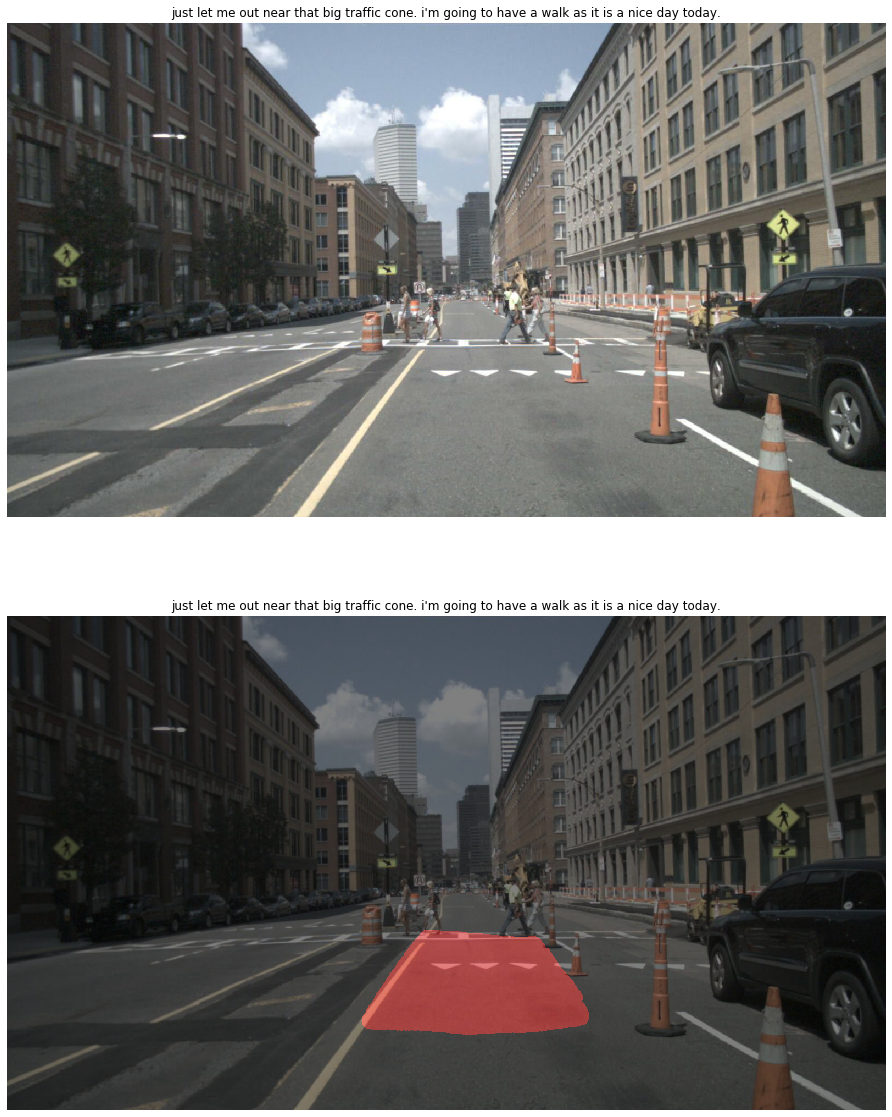

In [16]:
index = random.choice(range(data_len))
command = data[index]['command']

img_file = data[index]['img']
img_path = os.path.join(img_dir, img_file)

mask_file = f"gt_img_ann_{args.split}_{index}.png"
mask_path = os.path.join(mask_dir, mask_file)

img = Image.open(img_path)
img = np.array(img)

mask = Image.open(mask_path)
mask = np.array(mask)

img_overlay = img[:] / 2
mask_ = (mask > 0)
img_overlay[:, :, 0] += mask_.astype('uint8') * 100
img_overlay = img_overlay.astype('uint8')

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))

ax[0].imshow(img)
ax[0].set_title(command)
ax[0].set_axis_off()

ax[1].imshow(img_overlay)
ax[1].set_title(command)
ax[1].set_axis_off()

plt.show()

In [17]:
simple_command = summarizer(command)

In [18]:
print(f'Original Command:: {command}')
print(f'Simple Command:: {simple_command}')

Original Command:: just let me out near that big traffic cone. i'm going to have a walk as it is a nice day today.
Simple Command:: just let me out near that big traffic cone.


In [19]:
keywords = ["stop", "slow", "wait", "then", "speed", "change", "continue", "follow", "u-turn", "once"]

In [20]:
def intersection(command):
    count = 0
    words = []
    for key in keywords:
        if key in command:
            words.append(key)
            count += 1
    return count, words

In [21]:
non_temporal_count = 0
temporal_count = 0

max_word_count = 0

# command_dict = {}
# for key in keywords:
#     command_dict[key] = 0

counter = Counter()

for ind in range(data_len):
    command = data[ind]['command']
    
    for key in keywords:
        if key in command:
            counter.update({key:1})
    
    inter_count, inter_words = intersection(command)
    
    if inter_count == 0:
        non_temporal_count += 1
    else:
        temporal_count += 1
        if inter_count > max_word_count:
            max_word_count = inter_count
            print(command)
            print(inter_words, inter_count)

once the light turns green, turn left behind the silver car
['once'] 1
oh i see my friends white car that is parked over there. stop near by once you make the left turn.
['stop', 'once'] 2
pull over behind this bus and stop. once traffic is clear make a you-turn and drive in the opposite direction.
['stop', 'u-turn', 'once'] 3
see if the guy is waiting to cross the street. if so stop and let him pass then continue driving straight.
['stop', 'wait', 'then', 'continue'] 4


In [22]:
print(max_word_count, temporal_count, non_temporal_count)

4 452 711


In [23]:
print(counter, sum(counter.values()))

Counter({'stop': 149, 'follow': 135, 'slow': 76, 'wait': 44, 'continue': 27, 'then': 26, 'change': 24, 'u-turn': 18, 'once': 13, 'speed': 13}) 525
